Let's do all importing and other pre-stuff here

In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.signal import butter, filtfilt
#from sklearn.neighbors import LocalOutlierFactor

Import function

In [6]:
# Unzip the archive (if not done yet)
unzipped_file_path = os.path.join("..", "data", "app5-data", "unzipped_data")
if (not os.path.exists(unzipped_file_path)) or (not os.path.isdir(unzipped_file_path)):
    os.makedirs(unzipped_file_path, exist_ok=True)
    zipped_file_path = os.path.join("..", "data", "app5-data", "compressed.zip")
    # Unzip the archive
    with ZipFile(zipped_file_path, 'r') as zip_ref:
        zip_ref.extractall(unzipped_file_path)

In [10]:
# Load the raw-sample-level dataset
df = pd.read_csv("../data/processed/app5_dataset.csv")

# Confirm expected structure
print("Columns:", df.columns)
print("First few rows:\n", df.head())

feature_rows = []

for filename, group in df.groupby("file"):
    emg = group["emg"].dropna().values
    eog = group["eog"].dropna().values

    if len(emg) == 0 or len(eog) == 0:
        print(f"Skipping {filename} due to missing data")
        continue

    stage = group["stage"].iloc[0]
    set_type = group["set"].iloc[0]

    feature_rows.append({
        "file": filename,
        "set": set_type,
        "stage": stage,
        "emg_mean": np.mean(emg),
        "emg_std": np.std(emg),
        "emg_rms": np.sqrt(np.mean(emg ** 2)),
        "eog_mean": np.mean(eog),
        "eog_std": np.std(eog),
        "eog_rms": np.sqrt(np.mean(eog ** 2)),
    })

features_df = pd.DataFrame(feature_rows)
print(features_df.head())

# Sanity check
print("\nFeature table (first 5 rows):")
print(features_df.head())


Columns: Index(['eog', 'emg', 'stage', 'set', 'file'], dtype='object')
First few rows:
     eog  emg  stage    set           file
0  39.0  3.0  awake  Train  0_subj_10.csv
1  36.0  4.0  awake  Train  0_subj_10.csv
2  36.0  2.0  awake  Train  0_subj_10.csv
3  40.0 -5.0  awake  Train  0_subj_10.csv
4  46.0 -2.0  awake  Train  0_subj_10.csv
            file    set   stage  emg_mean    emg_std    emg_rms  eog_mean  \
0   0_subj_1.csv  Train  nonrem -0.002667   4.100060   4.100061 -0.044000   
1  0_subj_10.csv  Train   awake  0.002083  11.015644  11.015644 -0.590083   
2  0_subj_11.csv  Train   awake  0.001250   4.281014   4.281014 -0.329667   
3  0_subj_12.csv   Test   awake  0.002167  14.235899  14.235899 -0.664750   
4  0_subj_13.csv  Train   awake  0.004250   5.016463   5.016465  1.029250   

     eog_std    eog_rms  
0   9.080229   9.080336  
1  40.073342  40.077686  
2  15.096500  15.100099  
3  78.400544  78.403362  
4  14.393438  14.430191  

Feature table (first 5 rows):
          

Sample AWAKE signal


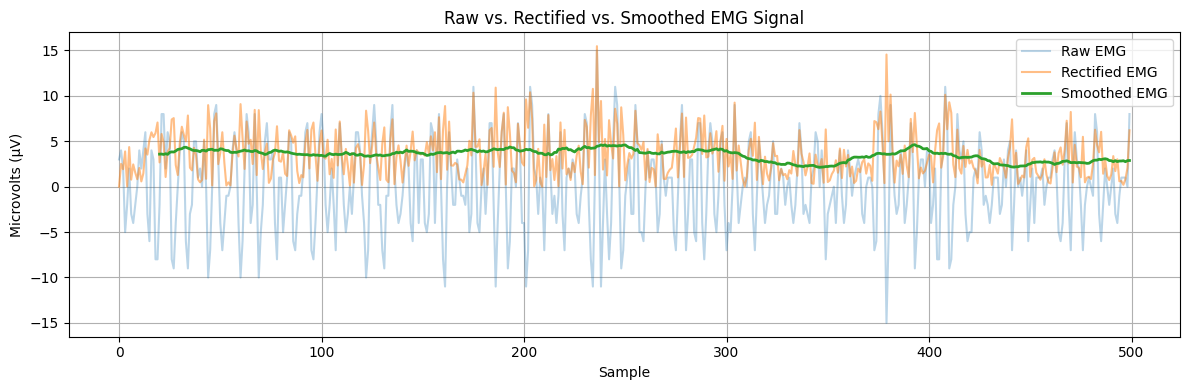

Sample REM signal


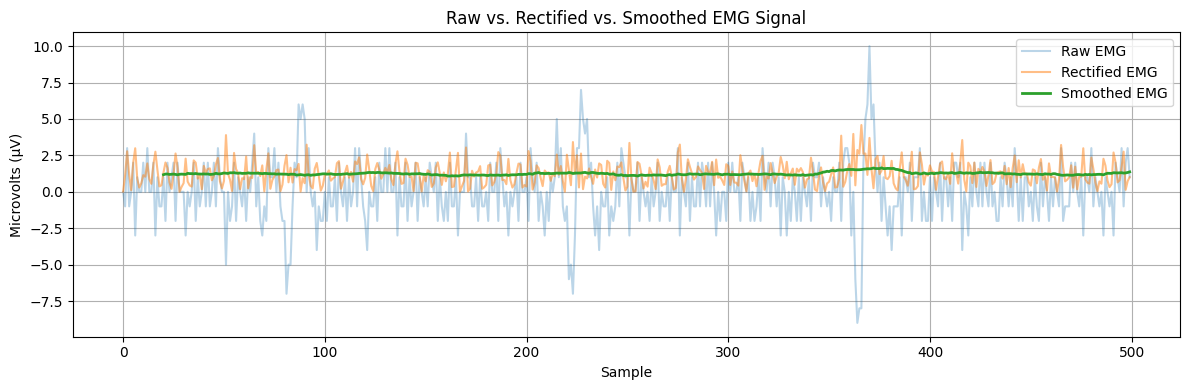

In [11]:
# Step 1: High-pass filter definition
def butter_highpass(cutoff, fs, order=4):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    return butter(order, normal_cutoff, btype='high', analog=False)

def highpass_filter(data, cutoff=20, fs=200, order=4):
    b, a = butter_highpass(cutoff, fs, order)
    return filtfilt(b, a, data)

# Preprocess and plot EMG from a sample
def preprocess_and_plot_emg(raw_df, fs=200):
    raw_emg = np.nan_to_num(raw_df['emg'].values, nan=0.0)

    # High-pass filter
    emg_filtered = highpass_filter(raw_emg, cutoff=20, fs=fs)

    # Rectify
    emg_rectified = np.abs(emg_filtered)

    # Smooth with moving average (200 ms window)
    window = int(0.2 * fs)
    emg_smoothed = pd.Series(emg_rectified).rolling(window=window, center=True).mean()
    
    # Plot all stages
    plt.figure(figsize=(12, 4))
    plt.plot(raw_emg[:500], label='Raw EMG', alpha=0.3)
    plt.plot(emg_rectified[:500], label='Rectified EMG', alpha=0.5)
    plt.plot(emg_smoothed[:500], label='Smoothed EMG', linewidth=2)
    plt.title('Raw vs. Rectified vs. Smoothed EMG Signal')
    plt.xlabel('Sample')
    plt.ylabel('Microvolts (μV)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return emg_smoothed

# Example usage: pick a file for each sleep stage
awake_file = df[df['stage'] == 'awake']['file'].iloc[0]
rem_file = df[df['stage'] == 'rem']['file'].iloc[0]

# Extract the signal for that file
awake_df = df[df['file'] == awake_file]
rem_df = df[df['file'] == rem_file]

# Plot and preprocess
print("Sample AWAKE signal")
preprocessed_awake = preprocess_and_plot_emg(awake_df)

print("Sample REM signal")
preprocessed_rem = preprocess_and_plot_emg(rem_df)


Simplified Machine Learning pipeline

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

# Use your existing features_df directly
df = features_df.copy()

# Encode labels
label_map = {"awake": 0, "rem": 1, "nonrem": 2}
df["stage_encoded"] = df["stage"].map(label_map)

# Split using the 'set' column
X_train = df[df["set"] == "Train"].drop(columns=["file", "set", "stage", "stage_encoded"])
y_train = df[df["set"] == "Train"]["stage_encoded"]

X_test = df[df["set"] == "Test"].drop(columns=["file", "set", "stage", "stage_encoded"])
y_test = df[df["set"] == "Test"]["stage_encoded"]

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_scaled, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test_scaled)
print("Classification report:")
print(classification_report(y_test, y_pred, target_names=label_map.keys()))

print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))

Classification report:
              precision    recall  f1-score   support

       awake       0.69      0.60      0.64        60
         rem       0.56      0.48      0.52        31
      nonrem       0.48      0.58      0.52        59

    accuracy                           0.57       150
   macro avg       0.58      0.55      0.56       150
weighted avg       0.58      0.57      0.57       150

Confusion matrix:
[[36  2 22]
 [ 1 15 15]
 [15 10 34]]
